(un-lab)=
# Uczenie nienadzorowane

In [1]:
import numpy as np              # numeric
import matplotlib.pyplot as plt # plotting
import statistics as st         # statistics
from IPython.display import display, Image # display imported graphics

In [2]:
import os.path 

isdir = os.path.isdir('lib_nn') # check whether 'lib_nn' exists

if not isdir:
   !git clone https://github.com/bronwojtek/lib_nn.git # cloning the library from github

import sys                     
sys.path.append('./lib_nn') 

from neural import *            # importing my library package

Invoking __init__.py for neural


```{admonition} Motto
:class: tip

*teachers! leave those kids alone!*

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (Pink Floyd, Another Brick In The Wall)
                             
```

Uczenie nadzorowane, omawiane w poprzednich wykładach, wymaga nauczyciela lub próbki treningowej z etykietami, gdzie znamy **a priori** cechy danych (np. jak w jednym z naszych przykładów, czy dany punkt jest wewnątrz czy na zewnątrz okręgu).
Jest to jednak dość szczególna sytuacja, ponieważ najczęściej dane, z którymi się stykamy, nie mają przypisanych etykiet i ,,są, jakie są". Ponadto, z neurobiologicznego czy metodologicznego punktu widzenia, wielu faktów i czynności uczymy się ,,na bieżąco", klasyfikując je, a następnie rozpoznając, przy czym proces ten przebiega bez żadnego zewnętrznego nadzoru czy etykietek ,,unoszących się" w powietrzu nad obiektami.

Wyobraźmy sobie botanika-kosmitę, który wchodzi na łąkę i napotyka różne gatunki kwiatów. Nie ma zielonego pojęcia, czym one są i czego się spodziewać, ponieważ nie ma żadnej wiedzy o sprawach ziemskich. Po znalezieniu pierwszego kwiatu zapisuje jego cechy: kolor, wielkość, liczbę płatków, zapach itd. Idzie dalej, znajduje inny kwiat, zapisuje jego cechy, i tak dalej i dalej dla kolejnych kwiatami. W pewnym momencie trafia jednak na kwiat, który już wcześniej poznał. Dokładniej mówiąc, jego cechy są bardzo zbliżone, choć nie identyczne (wielkość może się nieco różnić, kolor itd.), do poprzedniego przypadku. Stąd wniosek, że należy on do jednej kategorii. Poszukiwania trwają dalej, a nowe kwiaty albo tworzą nową kategorię, albo dołączają do już istniejącej. Na koniec poszukiwań kosmina ma utworzony katalog kwiatów i może przypisać nazwy (etykiety) poszczególnym gatunkom: mak kukurydziany, krwawnik pospolity, dziewanna...  Etykiety te, czyli nazwy, są przydatne w dzieleniu się swoją wiedzą z innymi, ponieważ podsumowują cechy kwiatu. Należy jednak pamiętać, że etykiety te nigdy nie były używane w procesie eksploracji (uczenia się) łąki.


Formalnie rzecz biorąc, opisywany problem **uczenia nienadzorowanego** dotyczy klasyfikacji danych (podziału na kategorie, lub **klastry**, czyli podzbiory próbki danych, w których odpowiednio zdefiniowane odległości między poszczególnymi danymi są małe, mniejsze od przyjętych odległości między klastrami). Mówiąc kolokwialnie, szukamy podobieństw między poszczególnymi punktami danych i staramy się podzielić próbkę na grupy podobnych obiektów. 

## Klastry

Oto nasza uproszczona wersja eksploracji botanika-kosmity:
Rozważmy punkty na płaszczyźnie, które są generowane losowo. Ich rozkład nie jest jednorodny, lecz rozłożony w czterech skupiskach: A, B, C i D. Możemy na przykład zadać odpowiednie granice dla współrzędnych $x_1$ i $x_2$ przy losowym generowaniu punktów danej kategorii. Używamy do tego funkcji numpy **random.uniform(a,b)**, dającej równomiernie rozłożoną liczbę zmiennoprzecinkową pomiędzy a i b: 

In [3]:
def pA():
    return [np.random.uniform(.75, .95), np.random.uniform(.7, .9)] 

def pB():
    return [np.random.uniform(.4, .6), np.random.uniform(.6, .75)] 

def pC():
    return [np.random.uniform(.1, .3), np.random.uniform(.4, .5)] 

def pD():
    return [np.random.uniform(.7, .9), np.random.uniform(0, .2)] 

Utwórzmy próbkę danych zawierającą po kilka punktów z każdej kategorii:

In [4]:
samA=np.array([pA() for _ in range(10)])
samB=np.array([pB() for _ in range(7)])
samC=np.array([pC() for _ in range(9)])
samD=np.array([pD() for _ in range(11)])

Dane te wyglądają następująco:

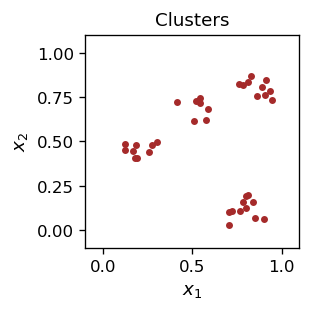

In [5]:
plt.figure(figsize=(2.3,2.3),dpi=120)
plt.title("Clusters",fontsize=11) 

plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)

plt.scatter(samA[:,0],samA[:,1],c='brown', s=10)
plt.scatter(samB[:,0],samB[:,1],c='brown', s=10)
plt.scatter(samC[:,0],samC[:,1],c='brown', s=10)
plt.scatter(samD[:,0],samD[:,1],c='brown', s=10)

plt.xlabel('$x_1$',fontsize=11)
plt.ylabel('$x_2$',fontsize=11)
plt.show()

Jeśli pokażemy komuś powyższy rysunek, to z pewnością stwierdzi, że są na nim cztery klastry. Ale jaka metoda jest używany, aby to stwierdzić? Wkrótce skonstruujemy odpowiedni algorytm i będziemy mogli przeprowadzić klasteryzację. Na razie jednak skoczmy w przód i załóżmy, że **wiemy**, czym są klastry. W naszym przykładzie klastry są dobrze zdefiniowane, tzn. widocznie oddzielone od siebie. 

Można reprezentować klastry za pomocą **punktów reprezentatywnych**, które leżą gdzieś w obrębie klastra. Można na przykład wziąć element należący do danego klastra jako jego reprezentanta, lub też dla każdego klastra oszacować średnie położenie jego punktów i użyć je jako punkt reprezentatywny:

In [6]:
rA=[st.mean(samA[:,0]),st.mean(samA[:,1])]
rB=[st.mean(samB[:,0]),st.mean(samB[:,1])]
rC=[st.mean(samC[:,0]),st.mean(samC[:,1])]
rD=[st.mean(samD[:,0]),st.mean(samD[:,1])]

(do obliczenia średniej użyliśmy modułu **statistics**). Tak zdefiniowane punkty reprezentatywne dołączamy do powyższej grafiki. Dla wygody wizualnej, każdej kategorii przypisujemy kolor (po ustaleniu klastów możemy bowiem nadać im etykiety, a kolor w tym przypadku służy właśnie temu celowi).

In [7]:
col=['red','blue','green','magenta']

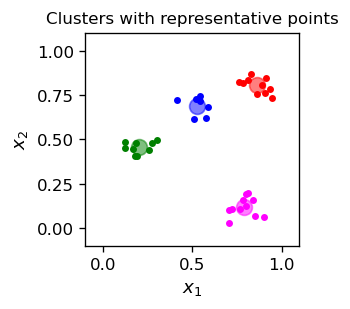

In [8]:
plt.figure(figsize=(2.3,2.3),dpi=120)
plt.title("Clusters with representative points",fontsize=10) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)

plt.scatter(samA[:,0],samA[:,1],c=col[0], s=10)
plt.scatter(samB[:,0],samB[:,1],c=col[1], s=10)
plt.scatter(samC[:,0],samC[:,1],c=col[2], s=10)
plt.scatter(samD[:,0],samD[:,1],c=col[3], s=10)

plt.scatter(rA[0],rA[1],c=col[0], s=90, alpha=0.5)
plt.scatter(rB[0],rB[1],c=col[1], s=90, alpha=0.5)
plt.scatter(rC[0],rC[1],c=col[2], s=90, alpha=0.5)
plt.scatter(rD[0],rD[1],c=col[3], s=90, alpha=0.5)

plt.xlabel('$x_1$',fontsize=11)
plt.ylabel('$x_2$',fontsize=11)
plt.show()

(vor_lab)=
## [Komórki Woronoja](https://en.wikipedia.org/wiki/Voronoi_diagram)

W sytuacji jak na rysunku powyżej, tzn. mając wyznaczone punkty reprezentatywne, możemy podzielić całą płaszczyznę na komórki (obszary) według następującego kryterium Woronoja, które jest prostym pojęciem geometrycznym:


```{admonition} Komórki Woronoja
:class: important

Rozważmy przestrzeń metryczną, w której istnieje pewna liczba punktów reprezentatywnych (punktów Woronoja) $R$. Dla danego punktu $P$ wyznaczamy odległości do wszystkich punktów $R$. Jeśli wśród tych odległości istnieje ścisłe minimum (najbliższy punkt $R_m$), to z definicji punkt $P$ należy do komórki Woronoja $R_m$. Jeśli nie ma ścisłego minimum, to $P$ należy do granicy między pewnymi komórkami. Konstrukcja ta dzieli całą przestrzeń na kopmórki Woronoja i granice pomiędzy nimi.
```

Wracając do naszego przykładu, zdefiniujmy kolor punktu P jako kolor najbliższego punktu reprezentatywnego. W tym celu potrzebujemy (kwadratu) odległości (tutaj euklidesowej) między dwoma punktami w przestrzeni dwuwymiarowej:

In [9]:
def eucl(p1,p2): # square of the Euclidean distance
    return (p1[0]-p2[0])**2+(p1[1]-p2[1])**2

Następnie z pomocą **np.argmin** znajdujemy najbliższy reprezentatywny punkt i określamy jego kolor:

In [10]:
def col_char(p):
    dist=[eucl(p,rA),eucl(p,rB),eucl(p,rC),eucl(p,rD)] # array of distances
    ind_min = np.argmin(dist)                          # index of the nearest point
    return col[ind_min]                                # color of the nearest point

Na przykład

In [11]:
col_char([.5,.5])

'blue'

Wynikiem przeprowadzenia tego kolorowania dla punktów z naszej przestrzeni (bierzemy tu wystarczająco gęstą próbkę $70 \times 70$ punktów) jest jej następujący podział na komórki Woronoja:

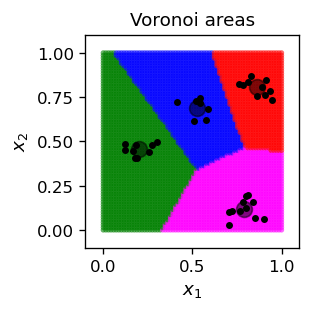

In [12]:
plt.figure(figsize=(2.3,2.3),dpi=120)
plt.title("Voronoi areas",fontsize=11) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)

for x1 in np.linspace(0,1,70): # 70 points in x
    for x2 in np.linspace(0,1,70): # 70 points in y
        plt.scatter(x1,x2,c=col_char([x1,x2]), s=10, alpha=0.6, edgecolors='none')

plt.scatter(samA[:,0],samA[:,1],c='black', s=10)
plt.scatter(samB[:,0],samB[:,1],c='black', s=10)
plt.scatter(samC[:,0],samC[:,1],c='black', s=10)
plt.scatter(samD[:,0],samD[:,1],c='black', s=10)

plt.scatter(rA[0],rA[1],c='black', s=90, alpha=.5)
plt.scatter(rB[0],rB[1],c='black', s=90, alpha=.5)
plt.scatter(rC[0],rC[1],c='black', s=90, alpha=.5)
plt.scatter(rD[0],rD[1],c='black', s=90, alpha=.5)

plt.xlabel('$x_1$',fontsize=11)
plt.ylabel('$x_2$',fontsize=11)
plt.show()

Łatwo jest udowodnić, że granice między sąsiednimi obszarami są liniami prostymi.

```{note}

Praktyczne przesłanie jest takie, że po wyznaczeniu punktów reprezentatywnych możemy zastosować kryterium Woronoja do klasyfikacji danych.
```

## Naiwna klasteryzacja

Wracamy teraz do problemu botanika-kosmity: wyobraźmy sobie, że mamy naszą próbkę, ale nie wiemy nic o tym, jak zostały wygenerowane jej punkty (nie mamy etykiet A, B, C, D ani kolorów punktów). Co więcej, dane są zmieszane, tzn. punkty danych występują w przypadkowej kolejności. Łączymy więc nasze punkty za pomocą **np.concatenate**:

In [13]:
alls=np.concatenate((samA, samB, samC, samD))

i tasujemy je z pomocą **np.random.shuffle**:

In [14]:
np.random.shuffle(alls)

Wizualizacja danych wygląda tak, jak na pierwszym wykresie w tym rozdziale.

Chcemy teraz w jakiś sposób utworzyć punkty reprezentatywne, ale a priori nie wiemy, gdzie powinny się one znajdować, ani nawet ile ich powinno być. Do osiągnięcia celu możliwe są bardzo różne strategie. Ich wspólną cechą jest to, że położenie punktów reprezentatywnych jest aktualizowane w miarę przetwarzania (czytania) danych próbki.

Zacznijmy od przypadku tylko jednego punktu reprezentatywnego, $vec{R}$. Nie jest to zbyt ambitne, ale przynajmniej będziemy znali pewne uśrednione charakterystyki próbki. Początkowa pozycja to $ R=(R_1, R_2) $, dwuwymiarowy wektor w przestrzeni $[0,1]\times [0,1]$. Po odczytaniu punktu danych $P$ o współrzędnych $ (x_1 ^ P, x_2 ^ P) $, wektor $R$ zmienia się w następujący sposób:


$$ (R_1, R_2) \to (R_1, R_2) + \varepsilon (x_1 ^P-R_1, x_2 ^P-R_2), $$

lub w notacji wektorowej

$$ \vec {R} \to \vec {R} + \varepsilon (\vec {x}^P - \vec {R}). $$

Czynność tę powtarzamy dla wszystkich punktów próbki, a następnie można wykonać wiele rund. Podobnie jak w poprzednich rozdziałach, $ \varepsilon $ jest współczynnikiem uczenia, który maleje
wraz z postępem algorytmu. Powyższy wzór realizuje "przyciąganie" punktu $\vec{R}$ przez punkt danych $vec{P}$.

Poniższy kod implementuje przepis:

In [15]:
R=np.array([np.random.random(),np.random.random()]) # initial location

print("initial location:")
print(np.round(R,3))
print("round   location")

eps=.5                         # initial learning speed

for j in range(50):            # rounds
    eps=0.85*eps               # decrease the learning speed 
    np.random.shuffle(alls)    # reshuffle the sample
    for i in range(len(alls)): # loop over points of the whole sample
        R+=eps*(alls[i]-R)     # update/learning
    if j%5==4: print(j+1, "    ",np.round(R,3))  # print every 5th step

initial location:
[0.89  0.811]
round   location
5      [0.57  0.473]
10      [0.62  0.505]
15      [0.617 0.487]
20      [0.604 0.489]
25      [0.613 0.491]
30      [0.615 0.491]
35      [0.616 0.492]
40      [0.616 0.493]
45      [0.616 0.493]
50      [0.616 0.493]


Można zauważyć, że położenie punktu reprezentatywnego jest zbieżne do pewnej granicy. W rzeczywistości dąży ono do średniego położenia punktów próbki, 

In [16]:
R_mean=[st.mean(alls[:,0]),st.mean(alls[:,1])]
print(np.round(R_mean,3))

[0.617 0.494]


Zdecydowaliśmy a priori, że będziemy mieli tylko jedną kategorię. Oto więc wykres z wynikiem dla punktu reprezentatywnenego, oznaczonego szarą plamą:

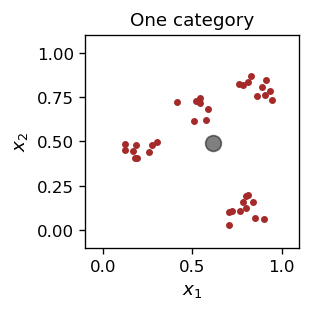

In [17]:
plt.figure(figsize=(2.3,2.3),dpi=120)
plt.title("One category",fontsize=11) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
       
plt.scatter(alls[:,0],alls[:,1],c='brown', s=10)

plt.scatter(R[0],R[1],c='black', s=90, alpha=.5)

plt.xlabel('$x_1$',fontsize=11)
plt.ylabel('$x_2$',fontsize=11)
plt.show()

Powyższe rozwiązanie oczywiście nas nie zadowala (na oko, obiekty nie należą do jednej kategorii), spróbujmy więc uogólnić algorytm na przypadek kilku ($n_R> 1$) punktów reprezentatywnych:

- Inicjalizujemy losowo punkty reprezentatywne $ \vec{R}^i $, $i = 1, \dots, n_R $.

- Runda: Bierzemy po kolei przykładowe punkty P i aktualizujemy tylko **najbliższy** punkt reprezentatywny $R^m$ do punktu P w danym kroku:

$$ \vec{R}^m \to \vec{R}^m + \varepsilon (\vec{x} - \vec{R}^m). $$

- Położenie pozostałych punktów reprezentatywnych pozostaje niezmienione. Strategia taka nazywana jest **zwycięzca bierze wszystko** (winner-take-all).

- Powtarzamy rundy, za każdym razem zmniejszając $\varepsilon$.

```{important}

Strategia **zwycięzca bierze wszystko** jest ważnym pojęciem w trenowaniu ANN. Konkurujące neurony w warstwie walczą o ,,nagrodę", a ten, który wygra, bierze ją w całości (jego wagi są aktualizowane), podczas gdy przegrani nie dostają nic.
```

Rozważmy teraz dwa punkty reprezentatywne, które inicjalizujemy losowo:

In [18]:
R1=np.array([np.random.random(), np.random.random()])
R2=np.array([np.random.random(), np.random.random()])

Następnie wykonujemy nasz algorytm. Dla każdego punktu danych znajdujemy najbliższy reprezentatywny punkt spośród dwóch i aktualizujemy tylko ten, który jest zwycięzcą:

In [19]:
print("initial locations:")
print(np.round(R1,3), np.round(R2,3))
print("rounds  locations")

eps=.5

for j in range(40):             
    eps=0.85*eps
    np.random.shuffle(alls) 
    for i in range(len(alls)):
        p=alls[i]   
        dist=[func.eucl(p,R1), func.eucl(p,R2)] # squares of distances
        ind_min = np.argmin(dist)               # index of the minimum
        if ind_min==0:         # if R1 closer to the new data point
            R1+=eps*(p-R1)     # update R1                
        else:                  # if R2 closer ... 
            R2+=eps*(p-R2)     # update R2       

    if j%5==4: print(j+1,"    ", np.round(R1,3), np.round(R2,3))  

initial locations:
[0.206 0.016] [0.211 0.153]
rounds  locations
5      [0.498 0.626] [0.799 0.127]
10      [0.573 0.676] [0.79  0.114]
15      [0.51  0.638] [0.79  0.118]
20      [0.539 0.65 ] [0.79  0.118]
25      [0.542 0.652] [0.79  0.118]
30      [0.543 0.653] [0.79  0.118]
35      [0.543 0.653] [0.79  0.118]
40      [0.543 0.653] [0.79  0.118]


Wynik jest następujący:

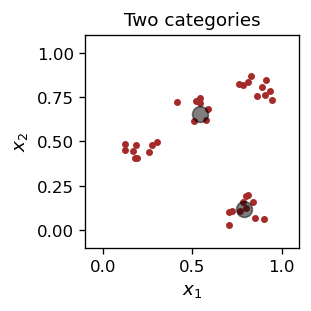

In [20]:
plt.figure(figsize=(2.3,2.3),dpi=120)
plt.title("Two categories",fontsize=11) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
       
plt.scatter(alls[:,0],alls[:,1],c='brown', s=10)

plt.scatter(R1[0],R1[1],c='black', s=90, alpha=.5)
plt.scatter(R2[0],R2[1],c='black', s=90, alpha=.5)

plt.xlabel('$x_1$',fontsize=11)
plt.ylabel('$x_2$',fontsize=11)
plt.show()

Jeden z punktów charakterystycznych ,,specjalizuje się" w prawym dolnym klastrze, a drugi w pozostałych punktach próbki.

Następnie kontynuujemy, całkiem analogicznie, z czterema punktami reprezentatywnymi.

initial locations:
[0.898 0.995] [0.346 0.35 ] [0.61 0.6 ] [0.748 0.98 ]
rounds   locations
[0.879 0.789] [0.771 0.114] [0.206 0.466] [0.535 0.677]
[0.865 0.804] [0.795 0.126] [0.194 0.459] [0.526 0.692]
[0.864 0.805] [0.792 0.117] [0.197 0.456] [0.527 0.689]
[0.864 0.805] [0.79  0.117] [0.198 0.456] [0.527 0.689]
[0.864 0.805] [0.79  0.118] [0.199 0.456] [0.527 0.689]
[0.864 0.805] [0.79  0.118] [0.199 0.456] [0.527 0.689]
[0.864 0.805] [0.79  0.118] [0.199 0.456] [0.528 0.689]
[0.864 0.805] [0.79  0.118] [0.199 0.456] [0.528 0.689]


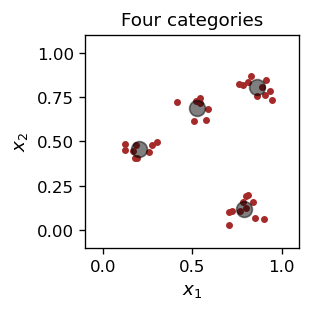

In [21]:
R1=np.array([np.random.random(), np.random.random()])
R2=np.array([np.random.random(), np.random.random()])
R3=np.array([np.random.random(), np.random.random()])
R4=np.array([np.random.random(), np.random.random()])


print("initial locations:")
print(np.round(R1,3), np.round(R2,3), np.round(R3,3), np.round(R4,3))   
print("rounds   locations")

eps=.5

for j in range(40):
    eps=0.85*eps
    np.random.shuffle(alls)
    for i in range(len(alls)):
        p=alls[i]
        dist=[func.eucl(p,R1), func.eucl(p,R2), func.eucl(p,R3), func.eucl(p,R4)]
        ind_min = np.argmin(dist)
        if ind_min==0:
            R1+=eps*(p-R1)
        elif ind_min==1:
            R2+=eps*(p-R2)  
        elif ind_min==2:
            R3+=eps*(p-R3)  
        else:
            R4+=eps*(p-R4)             

    if j%5==4: print(np.round(R1,3), np.round(R2,3), np.round(R3,3), np.round(R4,3))   

plt.figure(figsize=(2.3,2.3),dpi=120)
plt.title("Four categories",fontsize=11) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
       
plt.scatter(alls[:,0],alls[:,1],c='brown', s=10)

plt.scatter(R1[0],R1[1],c='black', s=90, alpha=.5)
plt.scatter(R2[0],R2[1],c='black', s=90, alpha=.5)
plt.scatter(R3[0],R3[1],c='black', s=90, alpha=.5)
plt.scatter(R4[0],R4[1],c='black', s=90, alpha=.5)

plt.xlabel('$x_1$',fontsize=11)
plt.ylabel('$x_2$',fontsize=11)
plt.show()

Wynik dla dwóch różnych warunków początkowych dla punktów reprezentatywnych (i nieco innej próbki) jest 
pokazany na {numref}`4p-fig`.

:::{figure-md} 4p-fig

<img src="images/cl4_2.png" width="500px">

Po lewej: właściwe punkty reprezentatywne. Po prawej: jeden ,,trup".
:::

Zauważamy, że procedura nie zawsze daje poprawną/oczekiwaną odpowiedź. Dość często jeden z punktów reprezentatywnych nie jest w ogóle aktualizowany i staje się tak zwanym **trupem**. Dzieje się tak dlatego, że pozostałe punkty reprezentatywne zawsze wygrywają, tzn. jeden z nich jest zawsze bliżej każdego punktu danych w próbce niż "trup". Oczywiście, jest to sytuacja niezadowalająca.

initial locations:
[0.482 0.297] [0.469 0.972] [0.18  0.965] [0.091 0.927] [0.552 0.123]
rounds   locations
[0.197 0.453] [0.886 0.806] [0.524 0.699] [0.091 0.927] [0.786 0.116]
[0.192 0.455] [0.864 0.807] [0.525 0.693] [0.091 0.927] [0.787 0.114]
[0.198 0.456] [0.864 0.804] [0.527 0.689] [0.091 0.927] [0.789 0.118]
[0.199 0.456] [0.863 0.805] [0.528 0.689] [0.091 0.927] [0.789 0.117]
[0.199 0.456] [0.864 0.805] [0.528 0.689] [0.091 0.927] [0.789 0.118]
[0.199 0.456] [0.864 0.805] [0.528 0.689] [0.091 0.927] [0.789 0.118]


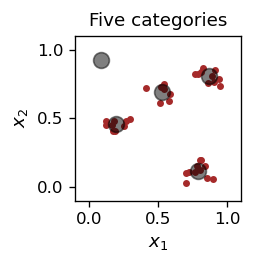

In [22]:
R1=np.array([np.random.random(), np.random.random()])
R2=np.array([np.random.random(), np.random.random()])
R3=np.array([np.random.random(), np.random.random()])
R4=np.array([np.random.random(), np.random.random()])
R5=np.array([np.random.random(), np.random.random()])

print("initial locations:")
print(np.round(R1,3), np.round(R2,3), np.round(R3,3), np.round(R4,3), np.round(R5,3))   
print("rounds   locations")


eps=.5

for j in range(30):
    eps=0.85*eps
    np.random.shuffle(alls)
    for i in range(len(alls)):
        p=alls[i]
        dist=[func.eucl(p,R1), func.eucl(p,R2), func.eucl(p,R3), func.eucl(p,R4), func.eucl(p,R5)]
        ind_min = np.argmin(dist)
        if ind_min==0:
            R1+=eps*(p-R1)
        elif ind_min==1:
            R2+=eps*(p-R2)  
        elif ind_min==2:
            R3+=eps*(p-R3)  
        elif ind_min==3:
            R4+=eps*(p-R4)  
        else:
            R5+=eps*(p-R5)             

    if j%5==4: 
        print(np.round(R1,3), np.round(R2,3), np.round(R3,3), np.round(R4,3), np.round(R5,3))   

plt.figure(figsize=(2.3,2.3),dpi=120)
plt.title("Five categories",fontsize=11) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
       
plt.scatter(alls[:,0],alls[:,1],c='brown', s=10)

plt.scatter(R1[0],R1[1],c='black', s=90, alpha=.5)
plt.scatter(R2[0],R2[1],c='black', s=90, alpha=.5)
plt.scatter(R3[0],R3[1],c='black', s=90, alpha=.5)
plt.scatter(R4[0],R4[1],c='black', s=90, alpha=.5)
plt.scatter(R5[0],R5[1],c='black', s=90, alpha=.5)

plt.xlabel('$x_1$',fontsize=11)
plt.ylabel('$x_2$',fontsize=11)

plt.tight_layout()
plt.show()

Gdy bierzemy pięć punktów reprezentatywnych, to w zależności od losowej inicjalizacji może wystąpić kilka sytuacji, jak pokazano na {numref}`5p-fig`. Czasami jakoś klaster rozpada się na dwa mniejsze, czasami pojawiają się trupy.

:::{figure-md} 5p-fig

<img src="images/cl5.jpg" width="870px">

Od lewej do prawej: 5 punktów charakterystycznych z jednym wcześniejszym klastrem podzielonym na dwa, z innym klasterm podzielonym na dwa, jednym trupem i dwoma trupami.
:::

Branie większej liczby punktów reprezentacyjnych prowadzi do jeszcze częstszego powstawania trupów. Oczywiście możemy je lekceważyć, ale przykład ten pokazuje, że obecna strategia klastrowanioa danych jest wysoce problematyczna i potrzebujemy czegoś lepszego. 

## Skala klastrowania

W poprzednim rozdziale staraliśmy się od początku odgadnąć, ile klastrów znajduje się w danych. Prowadziło to do problemów, gdyż zazwyczaj nie wiemy nawet, ile jest klastrów. Właściwie do tej pory nie zdefiniowaliśmy, czym dokładnie jest klaster, i posługiwaliśmy się jedynie intuicją. Ta intuicja podpowiadała nam, że punkty w tym samym skupisku muszą być blisko siebie lub blisko punktu charakterystycznego, ale jak blisko? Tak naprawdę definicja musi zawierać **skalę** (charakterystyczną odległość), która mówi nam, "jak blisko jest blisko". Na przykład w naszym przykładzie możemy przyjąć skalę około 0,2, gdzie są 4 klastry, ale możemy też przyjąć mniejszą skalę i rozdzielić większe klastry na mniejsze, jak w dwóch lewych panelach {numref}`5p-fig`.



```{admonition} Definicja klastra
:class: note

Klaster o skali $d$ związany z punktem charakterystycznym $R$ to zbiór punktów danych $P$, których odległość od $R$ jest mniejsza niż $d$, natomiast odległość od innych punktów reprezentatywnych jest  $\ge d$. Punkty charakterystyczne muszą być wybrane w taki sposób, aby każdy punkt danych należał do klastra, a żaden punkt charakterystyczny nie był martwy (tzn. jego klaster musi zawierać co najmniej jeden punkt danych).

```

Do realizacji tej recepty można wykorzystać różne strategie. Tutaj użyjemy **dynamicznej klasteryzacji**, w której nowy klaster/punkt reprezentatywny jest tworzony za każdym razem, gdy napotkany punkt danych znajduje się dalej niż $d$ od dowolnego punktu reprezentatywnego zdefiniowanego do tej pory.   

```{admonition} Dynamiczna klasteryzacja
:class: important

0. Ustaw skalę klasteryzacji $d$ i początkową szybkość uczenia $varepsilon$. Potasuj próbkę.

1. Odczytaj pierwszy punkt danych $P_1$ i wyznacz pierwszy punkt charakterystyczny jako $R^1=P_1$. Dodaj go do tablicy $R$ zawierającej wszystkie punkty charakterystyczne. Oznacz $P_1$ jako należący do klastra $1$. 

2. Odczytaj kolejny punkt danych $P$. Jeśli odległość $P$ od **najbliższego** punktu charakterystycznego, $R^m$, jest $\le d$, to 
    - oznacz $P$ jako należący do klastra $m$. 
    - przesuń $R^m$ w kierunku $P$ z prędkością uczenia $varepsilon$.     
W przeciwnym razie dodaj do $R$ nowy punkt charakterystyczny w położeniu punktu $P$. 

3. Powtórz od $2$, aż wszystkie punkty danych zostaną przetworzone. 

4. Powtórz od $2$ w pewnej liczbie rund, zmniejszając za każdym razem $\varepsilon$. Wynikiem jest podział próbki na pewną liczbę klastrów oraz położenia odpowiadających im punktów reprezentatywnych. Wynik może zależeć od losowego tasowania, a więc nie musi być taki sam przy powtarzaniu procedury.
```

Poniżej przedstawiono implementację w języku Python, dynamiczne znajdującą punkty reprezentatywne:

In [23]:
d=0.2   # clustering scale
eps=0.5 # initial learning speed

for r in range(20):               # rounds
    eps=0.85*eps                  # decrease the learning speed 
    np.random.shuffle(alls)       # shuffle the sample
    if r==0:                      # in the first round
        R=np.array([alls[0]])     # R - array of representative points
                                  # initialized to the first data point
    for i in range(len(alls)):    # loop over the sample points
        p=alls[i]                 # new data point
        dist=[func.eucl(p,R[k]) for k in range(len(R))] 
         # array of squares of distances of p from the current repr. points in R
        ind_min = np.argmin(dist) # index of the closest repr. point
        if dist[ind_min] > d*d:   # if its distance square > d*d
                                  # dynamical creation of a new category
            R=np.append(R, [p], axis=0)    # add new repr. point to R
        else:   
            R[ind_min]+=eps*(p-R[ind_min]) # otherwise, apdate the "old" repr. point

print("Number of representative points: ",len(R))

Number of representative points:  4


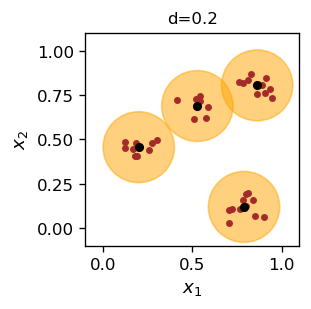

In [24]:
fig=plt.figure(figsize=(2.3,2.3),dpi=120)
plt.title("d="+str(d),fontsize=10) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
    
# drawing the circles
for k in range(len(R)):
    circ=plt.Circle((R[k][0],R[k][1]), radius=d, color='orange', fill=True, alpha=0.5)
    plt.gca().add_artist(circ)

# the sample points         
plt.scatter(alls[:,0],alls[:,1],c='brown', s=10 ,zorder=5)

# characteristic points
for k in range(len(R)):
    plt.scatter(R[k][0],R[k][1],c='black', s=20, zorder=10)

plt.xlabel('$x_1$',fontsize=11)
plt.ylabel('$x_2$',fontsize=11)
plt.show()

Wynik działania algorytmu dla różnych wartości skali klasteryzacji $d$ pokazano na {numref}`dyn-fig`. Przy bardzo małych wartościach $d$, mniejszych od minimalnej separacji między punktami, klastrów jest tyle, ile punktów danych. Następnie, wraz ze wzrostem wartości $d$, liczba klasrów maleje. Przy bardzo dużych wartościach $d$, rzędu rozpiętości całej próbki, występuje tylko jeden klaster.

:::{figure-md} dyn-fig

<img src="images/cd.jpg" width="770px">

Dynamiczne klastrowanie dla różnych wartości skali $d$.
:::

Oczywiście sam algorytm nie powie nam, jaką skalę klasteryzacji należy zastosować. Właściwa wartość zależy od natury problemu. Przypomnijmy sobie naszego botanika-kosmitę. Gdyby użył bardzo małej wartości $d$, otrzymałby tyle kategorii, ile jest kwiatów na łące, ponieważ wszystkie kwiaty, nawet tego samego gatunku, różnią się od siebie nieznacznie. Byłoby to bezużyteczne. Z drugiej strony, jeśli $d$ jest zbyt duże, to klasyfikacja jest zbyt zgrubna. Coś pomiędzy jest w sam raz!

```{admonition} Labels
:class: note

Po utworzeniu klastrów możemy dla wygody nadać im **etykiety**. Nie są one wykorzystywane w procesie uczenia (tworzenia klastrów).
```

Po określeniu klastrów mamy **klasyfikator**. Możemy go używać w dwojaki sposób:
   - kontynuować dynamiczną aktualizację w miarę napływu nowych danych lub
   - ,,zamknąć" klasyfikator i sprawdzić, gdzie wpadają nowe dane.
   
W pierwszym przypadku przyporządkowujemy nowemu punktowi danych odpowiednią etykietę klastra (nasz botanik wie, jaki nowy kwiat znalazł) lub tworzymy nową kategorię, jeśli punkt nie należy do żadnego z istniejących klastrów. Jest to po prostu kontynuacja opisanego powyżej algorytmu dla nowych przychodzących danych.

W drugim przypadku (kupiliśmy gotowy i zamknięty katalog botanika-kosmity) punkt danych może 
   - należeć do klastra (znamy jego etykietę), 
   - nie należeć do żadnego klastra, wtedy nie wiemy, co to jest, lub 
   - znaleźć się w obszarze nakładania się dwóch lub więcej klastrów (por. {numref}`dyn-fig`, kiedy otrzymujemy tylko "częściową" lub niejednoznaczną klasyfikację.
   
Alternatywnie, możemy zastosować klasyfikację z pomocą komórek Woronoja, aby pozbyć się niejednoznaczności.   

### Interpretacja poprzez najstromszy spadek

Oznaczmy dany klaster symbolem $C_i$, $i = 1, ..., n$, gdzie $ n$ jest całkowitą liczbą klastrów. Suma kwadratów odległości punktów danych w klastrze $ C_i $ od jego punktu reprezentatywnego $ R ^ i $ wynosi


  
$$
\sum_{P \in C_i} | \vec{R}^i- \vec{x}^P|^2.
$$

Sumując po wszystkich klastrach, otrzymujemy funkcję analogiczną do omówionej wcześniej funkcji błędu:

$$E (\{R \}) = \sum_{i = 1}^ n \sum_ {P \in C_i} |\vec{R}^i- \vec{x}^P |^2 .$$

Jej pochodna po $ \vec{R}_i $ wynosi

$$ \frac{\partial E (\{R \})}{\partial \vec{R}^i}
= 2 \sum_{P \in C_i} (\vec{R}^i- \vec{x}^P). $$

Metoda najstromszego spadku daje w rezultacie **dokładnie** taką samą receptę, jaką zastosowano w przedstawionym powyżej algorytmie dynamicznej klasteryzacji, tj.

$$ \vec{R} \to \vec{R} - \varepsilon (\vec{R} - \vec {x}^P). $$

Podsumowując, zastosowany algorytm polega w istocie na zastosowaniu metody najstromszego zejścia dla funkcji $ E (R) $, co zostało dokładniej omówione w poprzednich rozdziałach. 

```{note}
Należy jednak zauważyć, że minimalizacja stosowana w obecnym algorytmie uwzględnia również różne kombinatoryczne podziały punktów na klastry. W szczególności, dany punkt danych może zmienić swoje przyporządkowanie do klastra w trakcie wykonywania algorytmu. Dzieje się tak, gdy zmienia się jego najbliższy punkt reprezentatywny.

```

(inn-sec)=
## Interpretacja jako ANN

Zinterpretujemy teraz zastosowany powyżej algorytm uczenia nienadzorowanego ze strategią ,,zwycięzca bierze wszystko" w języku sieci neuronowych. Weźmy następującą przykładową sieć:

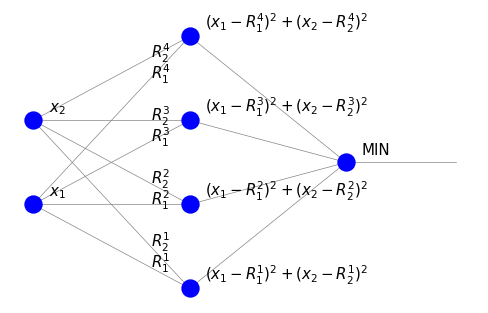

In [25]:
def plot_net_lab_0(n_war, wagi, x):
    li_war=len(n_war)
    plt.figure(figsize=(5,3),dpi=120) 

    for i in range(li_war): 
        for j in range(n_war[i]):  
            plt.scatter(i, j-n_war[i]/2, s=100,c='blue',zorder=10) 
            lab=x[i][j]
            plt.text(i+0.1, j-n_war[i]/2+0.1, lab, fontsize=9)
    
    for i in range(li_war-1):
        for j in range(n_war[i]):
            for k in range(n_war[i+1]):
                plt.plot([i,i+1],[j-n_war[i]/2,k-n_war[i+1]/2],c='gray',linewidth=0.4)
                plt.text(i+0.75, 0.25*(j-n_war[i]/2)+0.75*(k-n_war[i+1]/2), 
                         wagi[i+1][j][k], fontsize=9)
                
    # the last edge on the right
    for j in range(n_war[li_war-1]):
        plt.plot([li_war-1,li_war-1+0.7],
                 [j-(n_war[li_war-1])/2,j-(n_war[li_war-1])/2],c='gray',linewidth=0.4)
            

    plt.axis("off")
    plt.show()

plt.show(plot_net_lab_0([2,4,1],
             {1: [["$R_1^1$", "$R_1^2$", "$R_1^3$", "$R_1^4$"], 
                  ["$R_2^1$", "$R_2^2$", "$R_2^3$", "$R_2^4$"]], 
              2: [[""], [""], [""],[""]]} ,
             {0: np.array(["$x_1$","$x_2$"]), 
              1: np.array(["$(x_1-R_1^1)^2+(x_2-R_2^1)^2$",
                           "$(x_1-R_1^2)^2+(x_2-R_2^2)^2$",
                           "$(x_1-R_1^3)^2+(x_2-R_2^3)^2$", 
                           "$(x_1-R_1^4)^2+(x_2-R_2^4)^2$"]), 
              2: np.array(["MIN"])}))

Składa się ona z czterech neuronów w warstwie pośredniej, z których każdy odpowiada jednemu punktowi charakterystycznemu $\vec{R}^i$. Wagi są współrzędnymi punktu $\vec{R}^i$. W warstwie wyjściowej znajduje się jeden węzeł. Zauważamy istotne różnice w stosunku do omawianego wcześniej perceptronu.

- Nie ma węzłów progowych.

- W warstwie pośredniej sygnał jest równy kwadratowi odległości inputu od odpowiedniego punktu reprezentatywnego. Nie jest to suma ważona.

- Węzeł w ostatniej warstwie (MIN) wskazuje, w którym neuronie warstwy pośredniej sygnał jest najmniejszy, tzn. gdzie mamy najmniejszą odległość. Działa on zatem jako jednostka sterująca wybierająca minimum.

Podczas uczenia (nienadzorowanego) punkt wejściowy P ,,przyciąga'' najbliższy punkt charakterystyczny, którego wagi są aktualizowane w kierunku współrzędnych P.

Zastosowanie powyższej sieci klasyfikuje punkt o współrzędnych $(x_1, x_2)$, przypisując mu wskaźnik najbliższego punktu reprezentatywnego dla danej kategorii (tutaj jest to etykieta 1, 2, 3 lub 4).  

### Reprezentacja z pomocą  współrzędnych sferycznych

Nawet przy naszej ogromnej "swobodzie matematycznej" nazwanie powyższego systemu siecią neuronową byłoby sporym nadużyciem, ponieważ wydaje się on bardzo daleki od jakiegokolwiek wzorca neurobiologicznego. W szczególności, użycie (nieliniowego) sygnału w postaci $\left( \vec{R}^i-\vec{x}\right)^2$ kontrastuje z perceptronem, w którym sygnał wchodzący do neuronów jest (liniową) sumą ważoną inputów, tzn.

$$ s^ i = x_1 w_1 ^ i + x_2 w_2 ^ i + ... + w_1 ^ m x_m = \vec {x} \cdot \vec {w} ^ i. $$

Możemy zmienić nasz problem, stosując prostą konstrukcję geometryczną tak, aby upodobnić go do zasady działania perceptronu. W tym celu wprowadzamy (fikcyjną, pomocniczą) trzecią współrzędną zdefiniowaną jako

$$ x_3 = \sqrt {r ^ 2-x_1 ^ 2-x_2 ^ 2}, $$

gdie $ r $ jest dobrane tak, aby dla wszystkich punktów danych $ r ^ 2 \ge x_1 ^ 2 + x_2 ^ 2 $. Z konstrukcji, $ \vec {x} \cdot \vec {x} = x_1 ^ 2 + x_2 ^ 2 + x_3 ^ 2 = r ^ 2 $, więc punkty danych leżą na półkuli ($ x_3 \ge 0 $) o promieniu $ r $. Podobnie, dla punktów reprezentatywnych wprowadzamy

$$ w_1 ^ i = R_1 ^ i,  \; w_2 ^ i = R_2 ^ i,  \; 
w_3 ^ i = \sqrt {r ^ 2-(R_1 ^i)^2 -(R_2 ^i)^2}. $$

Jest geometrycznie oczywiste, że dwa punkty na płaszczyźnie są sobie bliskie wtedy i tylko wtedy, gdy ich rozszerzenia ndo półkuli są sobie bliskie. Stwierdzenie to poprzemy prostym rachunkiem:

Iloczyn skalarny dwóch punktów $\vec{x} $ i $\vec{y} $ na półkuli można zapisać jako

$$ \vec {x} \cdot \vec {y} = x_1 y_1 + x_2 y_2 + \sqrt {r ^ 2-x_1 ^ 2-x_2 ^ 2} \sqrt {r ^ 2-y_1 ^ 2-y_2 ^ 2}. $$

Dla uproszczenia rozważmy sytuację, w której $ x_1 ^ 2 + x_2 ^ 2 \ll r ^ 2 $ and $ y_1 ^ 2 + y_2 ^ 2 \ll r ^ 2 $, tj. obydwa punkty leżą w pobliżu bieguna półkuli. Korzystając z wiedzy z zakresu analizy matematycznej

$$ \sqrt{r^2-a^2} \simeq r - \frac{a^2}{2r},  \;\;\;a \ll r, $$ 

zatem

$$ \vec{x} \cdot \vec{y} \simeq x_1 y_1 + x_2 y_2 + \left( r -\frac{x_1^2+x_2^2}{2r} \right) \left( r -\frac{y_1^2+y_2^2}{2r} \right) \\ 
\;\;\;\simeq r^2 - \frac{1}{2} (x_1^2+x_2^2 +y_1^2+y_2^2) + x_1 y_1+x_2 y_2 \\ 
\;\;\; = r^2 - \frac{1}{2}[ (x_1-x_2)^2 +(y_1-y_2)^2]. $$

Iloczyn skalarny jest równy (dla punktów położonych blisko bieguna) stałej $ r ^ 2 $ minus połowa kwadratu odległości między punktami $ (x_1, x_2) $ i $ (y_1, y_2) $ na płaszczyźnie! Wynika z tego, że zamiast znajdować minimalną odległość dla punktów na płaszczyźnie, jak w poprzednim algorytmie, możemy znaleźć maksymalny iloczyn skalarny dla ich 3-wymiarowych rozszerzeń do półkuli.

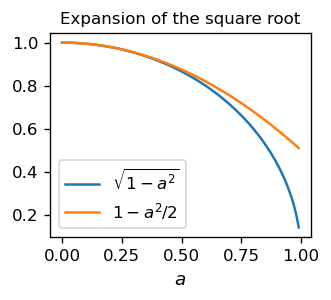

In [26]:
plt.figure(figsize=(2.8,2.2),dpi=120)
plt.title("Expansion of the square root",fontsize=10) 

s=np.arange(0,1,.01)
st=np.sqrt(1-s**2)
se=1-s**2/2

plt.plot(s,st)
plt.plot(s,se)

plt.legend(('$\sqrt{1-a^2}$','$1-a^2/2$'),fontsize=10)
plt.xlabel('$a$',fontsize=11)
plt.show()

Po rozszerzeniu danych do półkuli, odpowiednią sieć neuronową można przedstawić w następujący sposób:

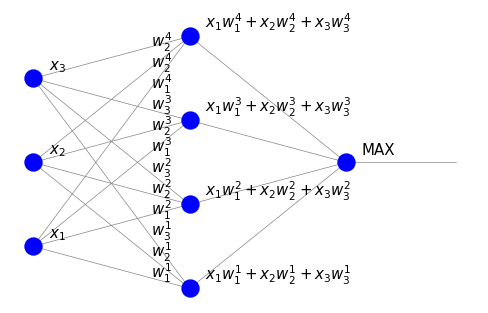

In [27]:
plt.show(plot_net_lab_0([3,4,1],
             {1: [["$w_1^1$", "$w_1^2$", "$w_1^3$", "$w_1^4$"], 
                  ["$w_2^1$", "$w_2^2$", "$w_2^3$", "$w_2^4$"],
                  ["$w_3^1$", "$w_3^2$", "$w_3^3$", "$w_2^4$"]], 
              2: [[""], [""], [""],[""]]} ,
             {0: np.array(["$x_1$","$x_2$","$x_3$"]), 
              1: np.array(["$x_1 w_1^1+x_2 w_2^1+x_3 w_3^1$",
                           "$x_1 w_1^2+x_2 w_2^2+x_3 w_3^2$",
                           "$x_1 w_1^3+x_2 w_2^3+x_3 w_3^3$", 
                           "$x_1 w_1^4+x_2 w_2^4+x_3 w_3^4$"]), 
              2: np.array(["MAX"])}))

Dzięki naszym staraniom sygnał w warstwie pośredniej jest teraz po prostu iloczynem skalarnym inputu i wag, dokładnie tak jak powinno być w sztucznym neuronie. Neuron w ostatniej warstwie (MAX) wskazuje, gdzie iloczyn skalarny jest największy. 

Interpretacja funkcji MAX w naszych obecnych ramach jest nadal nieco problematyczna. W rzeczywistości jest to możliwe, ale wymaga wyjścia poza sieci typu feed-forward. Gdy neurony w warstwie mogą się komunikować (sieci rekurencyjne, [sieci Hopfielda](https://en.wikipedia.org/wiki/Hopfield_network)), konkurować, a przy odpowiednim sprzężeniu zwrotnym można wymusić mechanizm ,,zwycięzca bierze wszystko". Aspekty te będą wspomniane w rozdz. {ref}`lat-lab''.

```{admonition} Reguła Hebba
:class: important

Od strony koncepcyjnej dotykamy tutaj bardzo ważnej i intuicyjnej zasady w biologicznych sieciach neuronowych, znanej jako [reguła Hebba] (https://en.wikipedia.org/wiki/Hebbian_theory). Zasadniczo odnosi się ona do stwierdzenia "To, co jest używane, staje się silniejsze" w odniesieniu do połączeń synaptycznych. Wielokrotne użycie połączenia sprawia, że staje się ono silniejsze.
```

W naszym sformułowaniu, jeśli sygnał przechodzi przez dane połączenie, jego waga odpowiednio się zmienia, podczas gdy inne połączenia pozostają bez zmian. Proces ten odbywa się w sposób nienadzorowany, a jego realizacja jest dobrze umotywowana biologicznie. 

```{note}

Z drugiej strony, trudno jest znaleźć biologiczne uzasadnienie dla uczenia nadzorowanego metodą backprop, w której wszystkie wagi są aktualizowane, także w warstwach bardzo odległych od wyjścia. Zdaniem wielu badaczy jest to raczej koncepcja matematyczna (niemniej niezwykle użyteczna).
```

### Maksymalizacja iloczynu skalarnego

Obecny algorytm klasteryzacji jest następujący:

- Przedłużamy punkty próbki o trzecią współrzędną, $ x_3 = \sqrt {r ^ 2-x_1 ^ 2-x_2 ^ 2} $, wybierając odpowiednio duże $ r $, aby $ r ^ 2> x_1 ^ 2 + x_2 ^ 2 $ dla wszystkich punktów próbki.

- Inicjalizujemy wagi w taki sposób, że $ \vec {w} _i \cdot \vec {w} _i = r ^ 2 $.

Następnie wykonujemy pętlę po punktach danych:

- Znajdujemy neuron w warstwie pośredniej, dla którego iloczyn skalarny $ x \cdot \vec {w} _i $ jest największy. Zmieniamy wagi tego neuronu wg. wzoru

$$ \vec {w} ^ i \to \vec {w} ^ i + \varepsilon (\vec {x} - \vec {w} ^ i). $$

- Renormalizujemy uaktualnione wagi $ \vec {w_i} $ tak, aby $ \vec {w} _i \cdot \vec {w} _i = r ^ 2 $:

$$ \vec {w} ^ i \to \vec {w} ^ i \frac {r} {\sqrt {\vec {w} _i \cdot \vec {w} _i}}. $$

Pozostałe kroki algorytmu, takie jak wyznaczanie początkowych położeń punktów reprezentatywnych, ich dynamiczne tworzenie w miarę napotykania kolejnych punktów danych itp. pozostają dokładnie takie same, jak w poprzednio omawianej procedurze.

Uogólnienie dla $n$ wymiarów jest oczywiste: wprowadzamy dodatkową współrzędną


$$ x_ {n + 1} = \sqrt {r ^ 2 - x_1 ^ 2 -...- x_n ^ 2},$$

mamy więc punkt na hiperhemisferze
 $ x_1 ^ 2 + \dots + x_n ^ 2 + x_ {n + 1} ^ 2 = r ^ 2 $,  $x_ {n + 1} >0$.

W Pythonie odpowiedni kod jest następujący:

In [28]:
d=0.25
eps=.5

rad=2    # radius of the hypersphere

for r in range(25):
    eps=0.85*eps
    np.random.shuffle(alls)
    if r==0:
        p=alls[0]
        R=np.array([np.array([p[0],p[1],np.sqrt(rad**2 - p[0]**2 - p[1]**2)])])
                                        # extension of R to the hypersphere
    for i in range(len(alls)):
        p=np.array([alls[i][0], alls[i][1], 
                    np.sqrt(rad**2 - alls[i][0]**2 - alls[i][1]**2)])
                                        # extension of p to the hypersphere
        dist=[np.dot(p,R[k]) for k in range(len(R))]      # array of dot products
        ind_max = np.argmax(dist)                         # maximum
        if dist[ind_max] < rad**2 - d**2/2:
             R=np.append(R, [p], axis=0)
        else:   
            R[ind_max]+=eps*(p-R[ind_max])

print("Number of representative points: ",len(R))

Number of representative points:  4


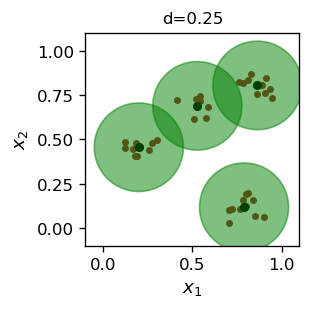

In [29]:
plt.figure(figsize=(2.3,2.3),dpi=120)
plt.title("d="+str(d),fontsize=10) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
    
# drawing the circles
for k in range(len(R)):
    circ=plt.Circle((R[k][0],R[k][1]), radius=d, color='green', fill=True, alpha=0.5)
    plt.gca().add_artist(circ)
     
plt.scatter(alls[:,0],alls[:,1],c='brown', s=10)

for k in range(len(R)):
    plt.scatter(R[k][0],R[k][1],c='black', s=20)

plt.xlabel('$x_1$',fontsize=11)
plt.ylabel('$x_2$',fontsize=11)
plt.show()

Można łatwo zauważyć, że algorytm maksymalizacji iloczynu skalarnego daje niemal dokładnie taki sam wynik jak minimalizacja kwadratu odległości (por. {numref}`dyn-fig`).

## Ćwiczenia

```{admonition} $~$
:class: warning

1. Metrykę miejską (Manhattanu) definiuje się jako

$ d (\vec {x}, \vec {y}) = | x_1-y_1 | + | x_2 - y_2 | $ dla punktów $ \vec {x} $ i $ \vec {y} $.
Powtórz symulacje z tego rozdziału, stosując tę metrykę. Wyciągnij wnioski.

2. Uruchom algorytm klasyfikacyjne dla większej liczby kategorii w próbce danych (wygeneruj własną próbkę). 

3. Rozszerz algorytm dynamicznej klasteryzacji na trójwymiarową przestrzeń danych.  
```